In [1]:
import numpy as np
import extra_func as ext
import matplotlib.pyplot as plt
%load_ext xsimlab.ipython
from adascape.fastscape_ext import adascape_IR12_model
import xsimlab as xs
from fastscape.models import basic_model
from fastscape.processes import Flexure
from adascape.fastscape_ext import IR12Speciation, FastscapeElevationTrait, CompoundEnvironment, ElevationEnvField, RandomSeedFederation
import xarray as xr

In [2]:
length = (250, 250)
spacing = (1, 1)
x, y = np.meshgrid(*[np.arange(0, l+s, s) for l, s in zip(length, spacing)])
environment = x * 10

In [3]:
%time df1 = ext.single_model_run(environment, x, y, sigma_u=0.2, K=30)

<IR12SpeciationModel (individuals: not initialized)>
Parameters:
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    taxon_threshold: 0.075
    taxon_def: traits
    rho: 0
    r: 50
    K: 30
    sigma_f: 0.2
    sigma_d: 30
    sigma_m: 0.05
    p_m: 0.005
    sigma_u: 0.2

CPU times: user 2.53 s, sys: 1.16 s, total: 3.69 s
Wall time: 2.71 s


In [4]:
%time df1_numba = ext.single_model_run(environment, x, y, sigma_u=0.2, K=30, numba_funcs=True)

<IR12SpeciationModel (individuals: not initialized)>
Parameters:
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    taxon_threshold: 0.075
    taxon_def: traits
    rho: 0
    r: 50
    K: 30
    sigma_f: 0.2
    sigma_d: 30
    sigma_m: 0.05
    p_m: 0.005
    sigma_u: 0.2

CPU times: user 4.48 s, sys: 1.27 s, total: 5.75 s
Wall time: 4.86 s


In [5]:
tree1 = df1.ptree.to_dendropy_tree()
#tree1.print_plot()

In [6]:
tree1_numba = df1_numba.ptree.to_dendropy_tree()
#tree1_numba.print_plot()

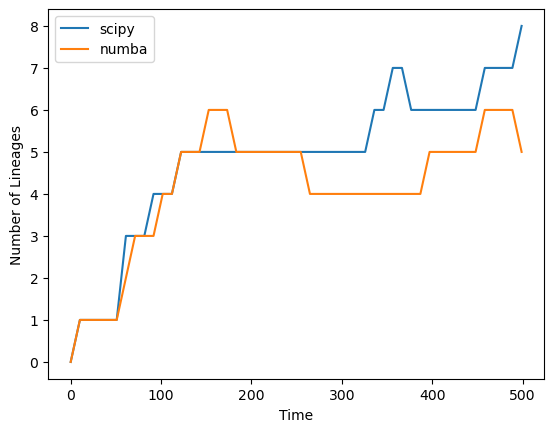

In [7]:
time_steps1 = np.linspace(0, tree1.max_distance_from_root(), 50)
ltt1=[tree1.num_lineages_at(t) for t in time_steps1]
time_steps2 = np.linspace(0, tree1_numba.max_distance_from_root(), 50)
ltt2 = [tree1_numba.num_lineages_at(t) for t in time_steps2]
plt.plot(time_steps1, ltt1, label='scipy')
plt.plot(time_steps2, ltt2, label='numba')
plt.xlabel('Time')
plt.ylabel('Number of Lineages')
plt.legend()

In [8]:
random_seed = 1234
the_clock = np.linspace(0., 1e6, 1001)

ds_in = xs.create_setup(
    model=adascape_IR12_model,
    clocks={
        'time': the_clock,
        'out': the_clock[::10]
    },
    master_clock='time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [101, 101],
        # total grid length in (y, x)
        'grid__length': [1e5, 1e5],
        # node status at borders
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        # uplift rate
        'uplift__rate': 5e-3,
        # random seed
        'init_topography__seed': random_seed,
        # diffusivity (transport coefficient)
        'diffusion__diffusivity': 1e-2,
        # bedrock channel incision coefficient
        'spl__k_coef': 1.8e-5,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # initial number of individuals
        'life__init_abundance': 100,
        # random number generator seed
        'life__random_seed': random_seed,
        # threshold used to construct taxon clusters
        'life__taxon_threshold': 0.1,
        # Taxon definition based on common ancestry and traits ('traits') or common ancestry,
        # traits and location ('traits_location')
        'life__taxon_def': 'traits',
        # min range of individuals on x coordinate
        'life__init_x_range_min': None,
        # min range of individuals on x coordinate
        'life__init_x_range_max': None,
        # min range of individuals on y coordinate
        'life__init_y_range_min': None,
        # min range of individuals on y coordinate
        'life__init_y_range_max': None,
        # Correlation coefficient between traits, 0 means that traits are independent, where a
        # value of rho different from 0 and between -1 and 1, will determine the degree of
        # correlation betweentraits for all individuals
        'life__rho': 0,
        # trait mediated competition for a limiting resource, where the degree of trait
        # similarity is given by this parameter. If its value is =>1 all individuals in the
        # local neighbourhood are counted, but if its values is < 1 then only those
        # individuals with similar trait values are counted.
        'life__sigma_u': 0.2,
        # environmental fitness selectivity or width around optimal traitvalue for each
        # individual's trait
        'life__sigma_f': 0.25,
        # dispersal variability in meters
        'life__sigma_d': 1e4,
        # trait variability of mutated offspring
        'life__sigma_m': 0.05,
        # mutation probability
        'life__p_m': 0.005,
        # fixed neighborhood radius
        'life__r': 2e4,
        # carrying capacity within a neighborhood
        'life__K': 25,
        # dispersal boundaries as an xr.DataArray with vertices [[x,y],...] of bounded area
        # with dimensions p and d
        'life__disp_boundary': None,
        # min initial trait value
        'trait_elev__init_trait_min': 0.25,
        # max initial trait value
        'trait_elev__init_trait_max': 0.25,
        # slope of opt. trait vs. elevation linear relationship
        'trait_elev__lin_slope': 0.95,
        # min elevation value for normalization
        'trait_elev__norm_min': 0,
        # max elevation value for normalization
        'trait_elev__norm_max': 3700,
        # min initial trait value
        'trait_prep__init_trait_min': 0.75,
        # max initial trait value
        'trait_prep__init_trait_max': 0.75,
        # slope of opt. trait vs. precipitation linear relationship
        'trait_prep__lin_slope': 0.95,
        # min precipitation value for normalization
        'trait_prep__norm_min': 1e-3,
        # max precipitation value for normalization
        'trait_prep__norm_max': 3.5,
        # random number generator seed
        'random__seed': random_seed,
        # environmental lapse rate
        'orographic__lapse_rate': -4,
        # moist adiabatic lapse rate
        'orographic__lapse_rate_m': -7,
        # reference saturation water vapor density
        'orographic__ref_density': 0.0074,
        # latitude
        'orographic__latitude': 40,
        # background, non-orographic precipitation rate
        'orographic__precip_base': 2.5,
        # daily rainfall frequency
        'orographic__rainfall_frequency': 1,
        # wind speed
        'orographic__wind_speed': 15,
        # wind direction (azimuth)
        'orographic__wind_dir': 0,
        # conversion time
        'orographic__conv_time': 1000,
        # fallout time
        'orographic__fall_time': 1000,
        # moist stability frequency
        'orographic__nm': 0.1,
        # water vapor scale height
        'orographic__hw': 3000,
        # minimum precipitation
        'orographic__precip_min': 1e-4,
    },
    output_vars={'topography__elevation': 'out',
            'orographic__precip_rate':'out',
            'life__x': 'out',
            'life__y': 'out',
            'life__traits': 'out',
            'life__taxon_id': 'out',
            'life__ancestor_id': 'out'}
)

/Users/eac/miniforge3/envs/adascape_dev/lib/python3.13/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'time' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)
/Users/eac/miniforge3/envs/adascape_dev/lib/python3.13/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'out' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


In [9]:
with adascape_IR12_model, xs.monitoring.ProgressBar():
    ds_out_wic = ds_in.xsimlab.run()

             0% | initialize 

In [10]:
with adascape_IR12_model, xs.monitoring.ProgressBar():
    ds_out_wic_numba = ds_in.xsimlab.update_vars(input_vars={'life': {'numba_funcs':True}}).xsimlab.run(check_dims='transpose')

             0% | initialize 

In [11]:
dtf_wic = ext.get_dataframe(ds_out_wic)
tree_wic = dtf_wic.rename(columns={'out':'time'}).ptree.to_dendropy_tree()
#tree_wic.print_plot()

In [12]:
dtf_wic_numba = ext.get_dataframe(ds_out_wic_numba)
tree_wic_numba = dtf_wic_numba.rename(columns={'out':'time'}).ptree.to_dendropy_tree()
#tree_wic_numba.print_plot()

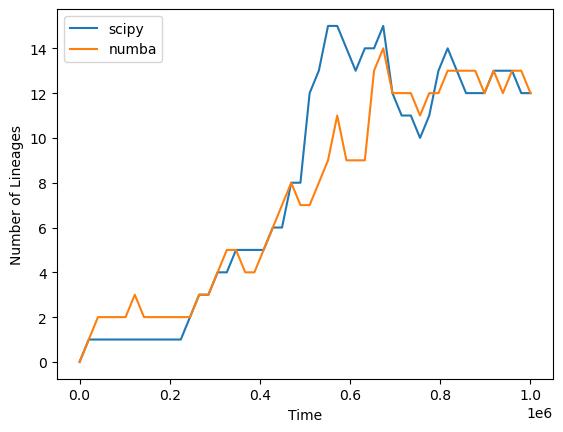

In [13]:
time_steps1 = np.linspace(0, tree_wic.max_distance_from_root(), 50)
ltt1=[tree_wic.num_lineages_at(t) for t in time_steps1]
time_steps2 = np.linspace(0, tree_wic_numba.max_distance_from_root(), 50)
ltt2 = [tree_wic_numba.num_lineages_at(t) for t in time_steps2]
plt.plot(time_steps1, ltt1, label='scipy')
plt.plot(time_steps2, ltt2, label='numba')
plt.xlabel('Time')
plt.ylabel('Number of Lineages')
plt.legend()

In [14]:
adascape_model = basic_model.update_processes(
    {'life': IR12Speciation,
     'trait_elev': FastscapeElevationTrait,
     'life_env': CompoundEnvironment,
     'elev_field': ElevationEnvField,
     'random': RandomSeedFederation}
)
adascape_model=adascape_model.update_processes({'flexure': Flexure}).drop_processes({'init_topography'})

clk = np.linspace(0, 25e6, 1001)
nx, ny = 101, 101
lx, ly = 1e5, 1e5
h0 = 1500

xx, yy = np.meshgrid(np.linspace(0,lx, nx), np.linspace(0,ly,ny))
island = np.where((((xx - 5e4) / (3e4)) ** 2 + ((yy - 5e4) / (4e4)) ** 2 <= 1),1,0)
boundary = np.column_stack([xx[island.astype('bool')], yy[island.astype('bool')]])

island = xr.DataArray(island, dims=('y', 'x'))

random_seed = 12345

In [15]:
def Ramer_Douglas_Peucker(points, epsilon):
    """
    Ramer-Douglas-Peucker algorithm.
    points: Nx2 numpy array of [x, y] coordinates
    epsilon: tolerance for simplification
    Returns: simplified Nx2 numpy array
    """
    if points.shape[0] < 3:
        return points

    stack = [(0, len(points) - 1)]
    keep = np.zeros(points.shape[0], dtype=bool)
    keep[0], keep[-1] = True, True

    while stack:
        start_idx, end_idx = stack.pop()
        start, end = points[start_idx], points[end_idx]

        line = end - start
        line_len = np.linalg.norm(line)
        if line_len == 0:
            continue

        vecs = points[start_idx+1:end_idx] - start
        if vecs.shape[0] == 0:
            continue

        dists = np.abs(line[0] * vecs[:,1] - line[1] * vecs[:,0]) / line_len

        idx_rel = np.argmax(dists)
        max_dist = dists[idx_rel]
        idx = start_idx + 1 + idx_rel

        if max_dist > epsilon:
            keep[idx] = True
            stack.append((start_idx, idx))
            stack.append((idx, end_idx))

    return points[keep]

In [16]:
def find_edges_polygon(points, nx, ny, lx, ly):
    # find edge points: any set of point with at least one neighbor 0
    edges = []
    for i in range(1, ny-1):
        for j in range(1, nx-1):
            if points[i,j] == 1 and np.any(points[i-1:i+2, j-1:j+2] == 0):
                edges.append((i,j))
    edges = np.array(edges)
    
    # map from grid indices to physical coordinates
    dx = lx / (nx-1)
    dy = ly / (ny-1)
    edge_coords = np.column_stack([edges[:,1]*dx, edges[:,0]*dy])
    
    # order points clockwise using centroid + angle method
    centroid = edge_coords.mean(axis=0)
    angles = np.arctan2(edge_coords[:,1]-centroid[1], edge_coords[:,0]-centroid[0])
    sorted_indices = np.argsort(angles)
    boundary_coords = edge_coords[sorted_indices]
    
    # ensure clockwise
    def is_clockwise(polygon):
        s = 0.0
        for i in range(len(polygon)):
            x1, y1 = polygon[i]
            x2, y2 = polygon[(i+1) % len(polygon)]
            s += (x2 - x1) * (y2 + y1)
        return s > 0
    
    if not is_clockwise(boundary_coords):
        boundary_coords = boundary_coords[::-1]
    
    return boundary_coords

In [17]:
%time rdp_boundary = Ramer_Douglas_Peucker(boundary, 0)

CPU times: user 2.12 ms, sys: 459 μs, total: 2.58 ms
Wall time: 2.21 ms


In [18]:
%time fep_boundary = find_edges_polygon(island, nx, ny, lx, ly)

CPU times: user 449 ms, sys: 9.16 ms, total: 458 ms
Wall time: 498 ms


In [19]:
from scipy.spatial import ConvexHull
cvhull = ConvexHull(boundary)
%time cvh_boundary = boundary[cvhull.vertices]

CPU times: user 6 μs, sys: 1e+03 ns, total: 7 μs
Wall time: 7.87 μs


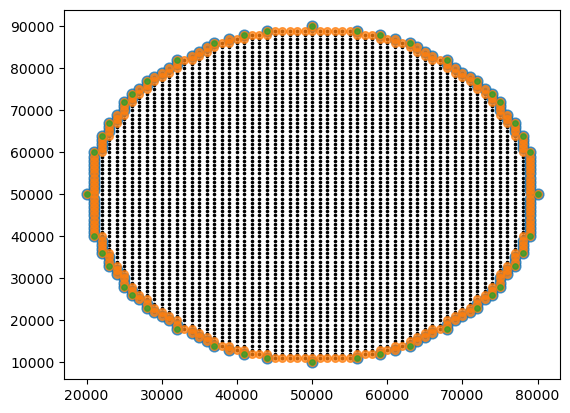

In [33]:
plt.scatter(boundary[:,0], boundary[:,1], s=2.5, c='black')
plt.scatter(rdp_boundary[:,0], rdp_boundary[:,1], s=60, alpha=0.75)
plt.scatter(fep_boundary[:,0], fep_boundary[:,1], s=30, alpha=0.75)
plt.scatter(cvh_boundary[:,0], cvh_boundary[:,1], s=15, alpha=0.75)

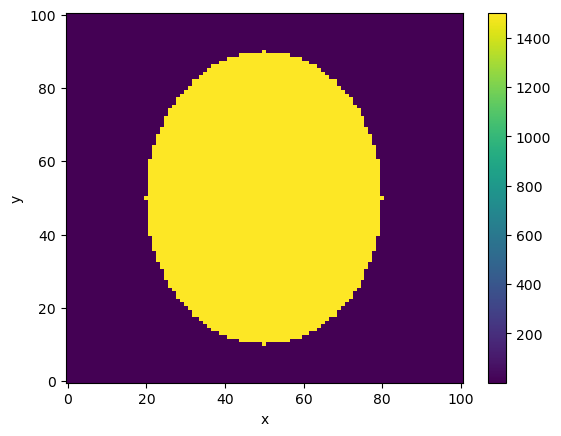

In [21]:
((island*h0) + np.random.random((ny, nx))).plot()

In [22]:
ds_in = xs.create_setup(
    model=adascape_model,
    clocks={'time':clk,
            'out':clk[::10]},
     master_clock='time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [ny, nx],
        # total grid length in (y, x)
        'grid__length': [ly, lx],
        # node status at borders
        'boundary__status': 'fixed_value',
        # uplift rate
        'uplift__rate': 0,
        # bedrock channel incision coefficient
        'spl__k_coef': island*3.0e-7,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # diffusivity (transport coefficient)
        'diffusion__diffusivity': 1e-2,
        # lithospheric rock density
        'flexure__lithos_density': 2600,
        # asthenospheric rock density
        'flexure__asthen_density': 3200,
        # effective elastic plate thickness
        'flexure__e_thickness': 5e4,
        # surface topography elevation
        'topography__elevation': (island*h0)+ np.random.random((ny, nx)), #
        # min initial trait value
        'trait_elev__init_trait_min': 0.75,
        # max initial trait value
        'trait_elev__init_trait_max': 0.75,
        # slope of opt. trait vs. elevation linear relationship
        'trait_elev__lin_slope': 0.95,
        # min elevation value for normalization
        'trait_elev__norm_min': 1,
        # max elevation value for normalization
        'trait_elev__norm_max': 2000,
        # initial number of individuals
        'life__init_abundance': 100,
        # random number generator seed
        'life__random_seed': random_seed,
        # threshold used to construct taxon clusters
        'life__taxon_threshold': 0.05,
        # Taxon definition based on common ancestry and traits ('traits') or common ancestry,
        # traits and location ('traits_location')
        'life__taxon_def': 'traits',
        # min range of individuals on x coordinate
        'life__init_x_range_min':  0.20*lx,
        # min range of individuals on x coordinate
        'life__init_x_range_max':  0.30*lx,
        # min range of individuals on y coordinate
        'life__init_y_range_min':  0.40*ly,
        # min range of individuals on y coordinate
        'life__init_y_range_max':  0.60*ly,
        # dispersal boundaries as an xr.DataArray with vertices [[x,y],...] of bounded area
        # with dimensions p and d
        'life__disp_boundary': xr.DataArray(cvh_boundary, dims=('p', 'd')),
        # Correlation coefficient between traits, 0 means that traits are independent, where a
        # value of rho different from 0 and between -1 and 1, will determine the degree of
        # correlation betweentraits for all individuals
        'life__rho': 0,
        # trait mediated competition for a limiting resource, where the degree of trait
        # similarity is given by this parameter. If its value is =>1 all individuals in the
        # local neighbourhood are counted, but if its values is < 1 then only those
        # individuals with similar trait values are counted.
        'life__sigma_u': 0.2,
        # environmental fitness selectivity or width around optimal traitvalue for each
        # individual's trait
        'life__sigma_f': 0.25,
        # dispersal variability in spatial units
        'life__sigma_d': 10e3,
        # trait variability of mutated offspring
        'life__sigma_m': 0.05,
        # mutation probability
        'life__p_m': 0.005,
        # fixed neighborhood radius
        'life__r': 2.0e4,
        # carrying capacity within a neighborhood
        'life__K': 50,
        # random number generator seed
        'random__seed': random_seed,
    },
    output_vars={'topography__elevation': 'out',
                 'flow__basin': 'out',
                 'grid__cell_area': 'out',
                 'life__x': 'out',
                 'life__y': 'out',
                 'life__traits': 'out',
                 'life__taxon_id': 'out',
                 'life__ancestor_id': 'out'}
)

/Users/eac/miniforge3/envs/adascape_dev/lib/python3.13/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'time' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)
/Users/eac/miniforge3/envs/adascape_dev/lib/python3.13/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'out' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


In [23]:
with adascape_model, xs.monitoring.ProgressBar():
    ds_island = ds_in.xsimlab.run()

             0% | initialize 

In [24]:
with adascape_model, xs.monitoring.ProgressBar():
    
    ds_island_numba = ds_in.xsimlab.update_vars(input_vars={'life': {'numba_funcs':True}}).xsimlab.run(check_dims='transpose')

             0% | initialize 

In [25]:
dtf_island = ext.get_dataframe(ds_island, out_vars=['life__taxon_id', 'life__ancestor_id',
                                'life__trait_elev', 'life__y', 'life__x'])
tree_island = dtf_island.rename(columns={'out':'time'}).ptree.to_dendropy_tree()

In [26]:
dtf_island_numba = ext.get_dataframe(ds_island_numba, out_vars=['life__taxon_id', 'life__ancestor_id',
                                'life__trait_elev', 'life__y', 'life__x'])
tree_island_numba = dtf_island_numba.rename(columns={'out':'time'}).ptree.to_dendropy_tree()

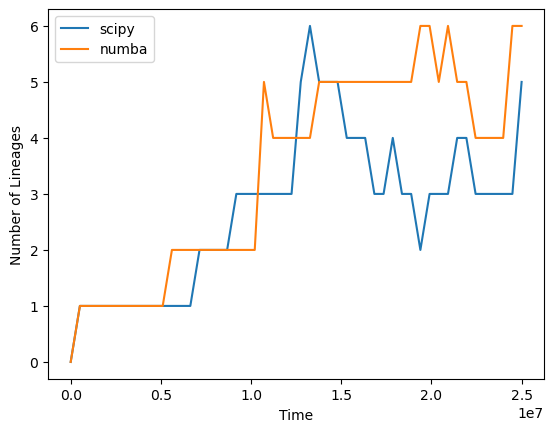

In [27]:
time_steps1 = np.linspace(0, tree_island.max_distance_from_root(), 50)
ltt1=[tree_island.num_lineages_at(t) for t in time_steps1]
time_steps2 = np.linspace(0, tree_island_numba.max_distance_from_root(), 50)
ltt2 = [tree_island_numba.num_lineages_at(t) for t in time_steps2]
plt.plot(time_steps1, ltt1, label='scipy')
plt.plot(time_steps2, ltt2, label='numba')
plt.xlabel('Time')
plt.ylabel('Number of Lineages')
plt.legend()

In [28]:
tree_island.print_plot()

                                                                        /+ 2711
                    /++++++++++++++++++++++++++++++++++++++++++++++++++++      
                    |                                                   |/ 2712
                    |                                                   \+     
                    |                                                    \ 2713
                    |                                                          
                    |            /---------------------------------------- 740 
+++++++++++++++++++++            |                                             
                    |     /+++++++   /----------------------------++++++++ 1405
                    |     |      |   |                                         
                    |     |      |   |                    /--------+++++++ 2352
                    |     |      \++++             /+++++++                    
                    |     |          |  

In [29]:
tree_island_numba.print_plot()

                                       /---------------------+++++++++++++ 2034
                               +++++++++                                       
                               |       |                /--------------+++ 2525
                               |       \+++++++++++++++++                      
               /++++++++++++++++                        |              /++ 3455
               |               |                        \+++++++++++++++       
               |               |                                       \++ 3456
               |               |                                               
               |               \-----------------------------------------+ 731 
++++++++++++++++                                                               
               |                                                       /++ 3457
               |              /+++++++++++++++++++++++++++++++++++++++++       
               |              |         

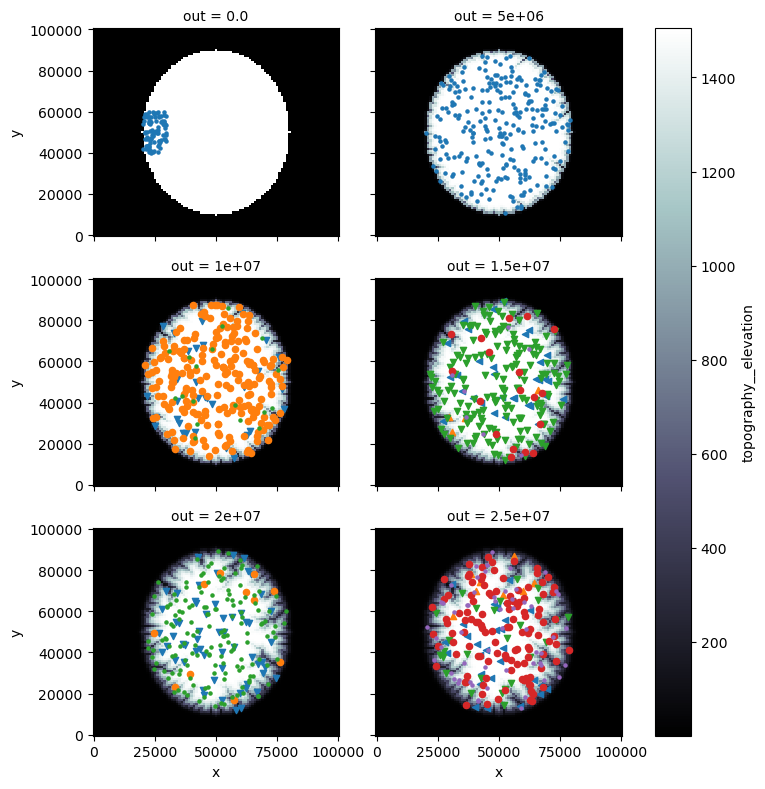

In [30]:
time_sel = np.arange(0,26e6, 5e6)
ext.plot_topo_taxa(ds_island, dtf_island, time_sel)

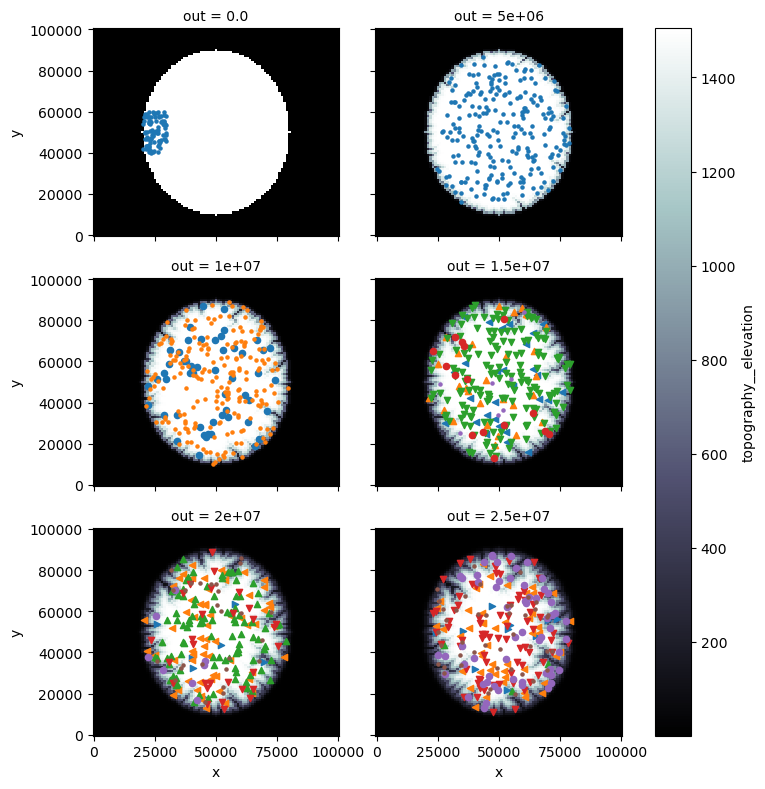

In [31]:
ext.plot_topo_taxa(ds_island_numba, dtf_island_numba, time_sel)